In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

### Import the testing dataset

In [2]:
# Load your dataset with columns 'tweet' and 'categories'
dataset = pd.read_csv("/Users/Hsuweic/Desktop/AI4health/dataset/testing dataset.csv")

print("Testing Set:"% dataset.columns, dataset.shape, len(dataset))
print(dataset.columns)

hate_speech_count = dataset['label'].sum()
print("Hate speech: ", hate_speech_count)
print("Non hate speech: ", len(dataset)-hate_speech_count)

Testing Set: (1000, 3) 1000
Index(['tweet', 'label', 'categories'], dtype='object')
Hate speech:  500
Non hate speech:  500


In [3]:
import re

def  clean_text(df, text_field):
    df[text_field] = df[text_field].str.lower()
    df[text_field] = df[text_field].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", str(elem)))  
    return df

data_clean = clean_text(dataset, 'tweet')

In [4]:
# Split the data into X_test and y_test with the feature column 'tweet' and the target column 'label'
X_test = data_clean['tweet']
y_test = data_clean['label']

hate_speech = dataset[dataset['label'] == 1].copy() 
hate_speech.reset_index(drop=True, inplace=True) # Reset the index to ensure it is consecutive
label_dict = {'Race': 0, 'Sexual Orientation': 1, 'Gender': 2, 'Disability': 3, 'Class': 4, 'Ethnicity': 5, 'Physical Appearance': 6, 'Religion': 7, 'Behavior': 8}
hate_speech['label'] = hate_speech['categories'].map(label_dict)
X_test_hate_speech = hate_speech['tweet']
y_test_hate_speech = hate_speech['label']
# print(X_test_hate_speech, y_test_hate_speech)

### Load the Detection model

                 precision    recall  f1-score   support

Non Hate Speech       0.57      0.95      0.72       500
    Hate Speech       0.86      0.29      0.44       500

       accuracy                           0.62      1000
      macro avg       0.72      0.62      0.58      1000
   weighted avg       0.72      0.62      0.58      1000



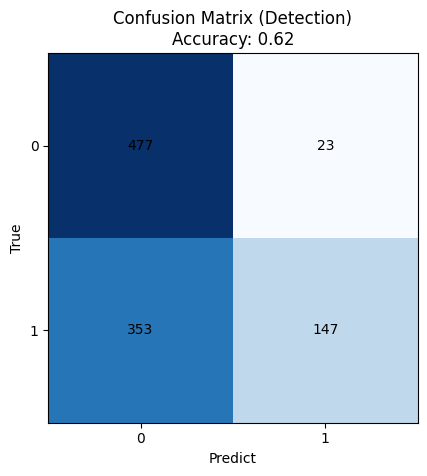

In [5]:
# Load the detection model
detection_model = joblib.load('/Users/Hsuweic/Desktop/AI4health/model/detection model.joblib')

class_labels = {0: 'Non Hate Speech', 1: 'Hate Speech'}

# Make predictions
y_predict = detection_model.predict(X_test)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_predict)
accuracy_detection = accuracy_score(y_test, y_predict)

# Create a confusion matrix plot
fig, ax = plt.subplots()

# Plot the confusion matrix
for (j, i), label in np.ndenumerate(cm):
    ax.text(i, j, label, ha='center', va='center')

# Display the accuracy in the title
ax.set_title(f'Confusion Matrix (Detection)\nAccuracy: {accuracy_detection:.2f}')

# # Customize the plot
ax.imshow(cm, cmap='Blues')
ax.set_xticks([1, 0])
ax.set_yticks([1, 0])
ax.set_xlabel('Predict')
ax.set_ylabel('True')

# Print classification report
print(classification_report(y_test, y_predict, target_names=class_labels.values()))


/var/folders/j5/b206ytkd1f52lmgd91ffpq1r0000gn/T/ipykernel_1995/4277660984.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  misclassified_hate_speech = misclassified_df[results_df['Actual'] == 1]


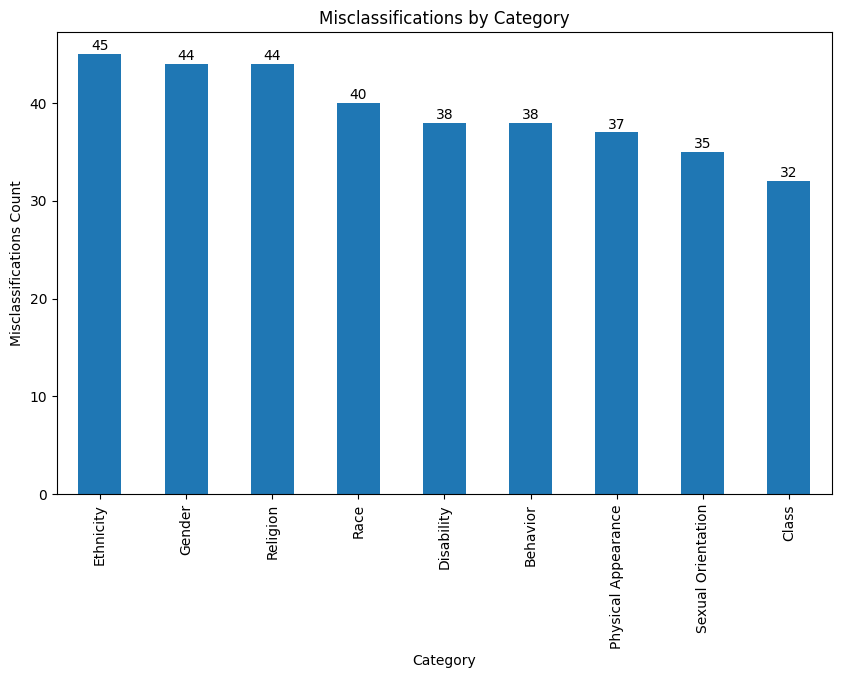

In [16]:
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_predict, 'Categories': data_clean['categories'], 'Tweet': X_test})
misclassified_df = results_df[results_df['Actual'] != results_df['Predicted']]
misclassified_hate_speech = misclassified_df[results_df['Actual'] == 1]
# print(len(misclassified_hate_speech), misclassified_hate_speech)

misclassifications_by_category = misclassified_hate_speech['Categories'].value_counts()

# Plotting
plt.figure(figsize=(10, 6))
bars = misclassifications_by_category.plot(kind='bar')

# Annotate each bar with the actual count
for bar in bars.patches:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.1, round(yval, 2), ha='center', va='bottom')

plt.xlabel('Category')
plt.ylabel('Misclassifications Count')
plt.title('Misclassifications by Category')
plt.show()

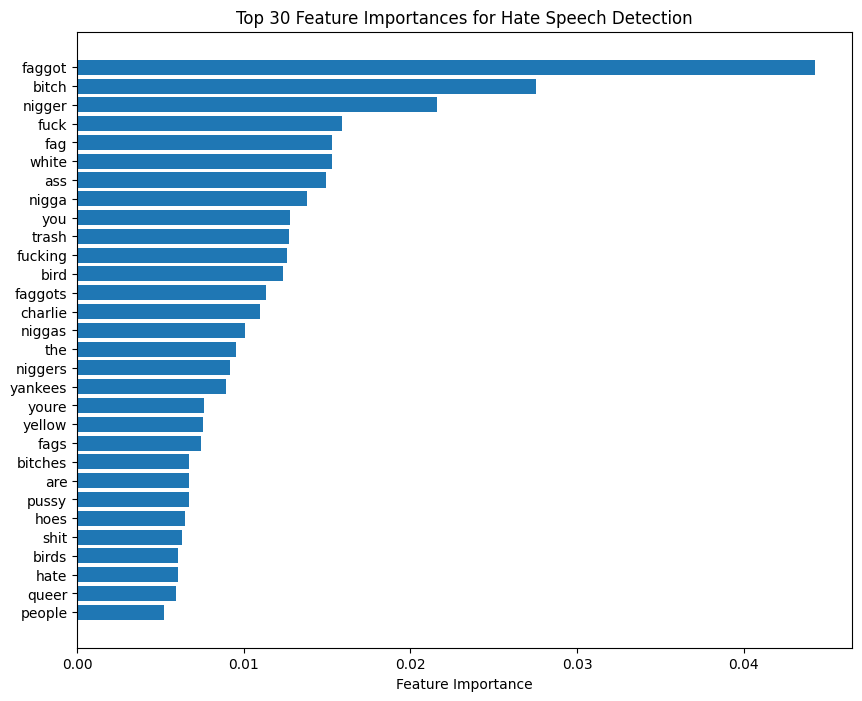

In [30]:
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier

# Load the vectorizer and TF-IDF transformer
vectorizer = detection_model.named_steps['vect']
tfidf_transformer = detection_model.named_steps['tfidf']

X_test_vectorized = vectorizer.transform(X_test)
X_test_tfidf = tfidf_transformer.transform(X_test_vectorized)

# Get feature names (words) from the vectorizer
feature_names = vectorizer.get_feature_names_out()

# Get the RandomForestClassifier from the pipeline
rf_classifier = detection_model.named_steps['rf']

# Get feature importances
feature_importances = rf_classifier.feature_importances_

# Map feature names to importance scores
feature_importance_dict = dict(zip(feature_names, feature_importances))
# print(len(feature_importance_dict))

# Sort features by importance
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Extract feature names and importances for plotting
top_features, importances = zip(*sorted_feature_importance[:30])

# Reverse the order
top_features = top_features[::-1]
importances = importances[::-1]

# Plotting
plt.figure(figsize=(10, 8))
plt.barh(range(len(top_features)), importances, align='center')
plt.yticks(range(len(top_features)), top_features)
plt.xlabel('Feature Importance')
plt.title('Top 30 Feature Importances for Hate Speech Detection')
plt.show()

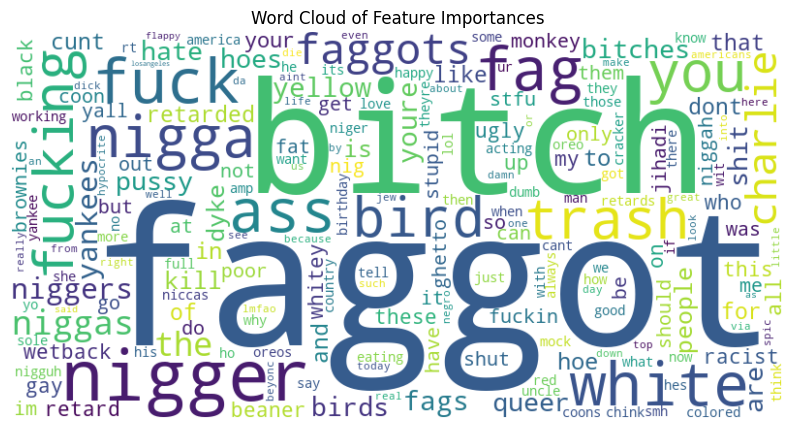

In [38]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(feature_importance_dict)
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Feature Importances')
plt.show()

### Load the Classification model
Label Dictionary:
{'Race': 0, 'Sexual Orientation': 1, 'Gender': 2, 'Disability': 3, 'Class': 4, 'Ethnicity': 5, 'Physical Appearance': 6, 'Religion': 7, 'Behavior': 8}

In [6]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch

# Load the BERTweet tokenizer and model for sequence classification
model_path = "/Users/Hsuweic/Desktop/AI4health/model/classification model_4"
tokenizer = AutoTokenizer.from_pretrained(model_path)
classification_model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=9)  # hate_categories = 9

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/Users/Hsuweic/Library/Python/3.8/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


BERTweet:
                     precision    recall  f1-score   support

               Race       0.41      0.80      0.54        64
 Sexual Orientation       0.77      0.84      0.80        56
             Gender       0.72      0.23      0.35        56
         Disability       0.53      0.72      0.61        54
              Class       0.61      0.46      0.53        54
          Ethnicity       0.38      0.43      0.40        54
Physical Appearance       0.94      0.30      0.46        56
           Religion       0.92      0.94      0.93        52
           Behavior       0.24      0.22      0.23        54

           accuracy                           0.55       500
          macro avg       0.61      0.55      0.54       500
       weighted avg       0.61      0.55      0.54       500



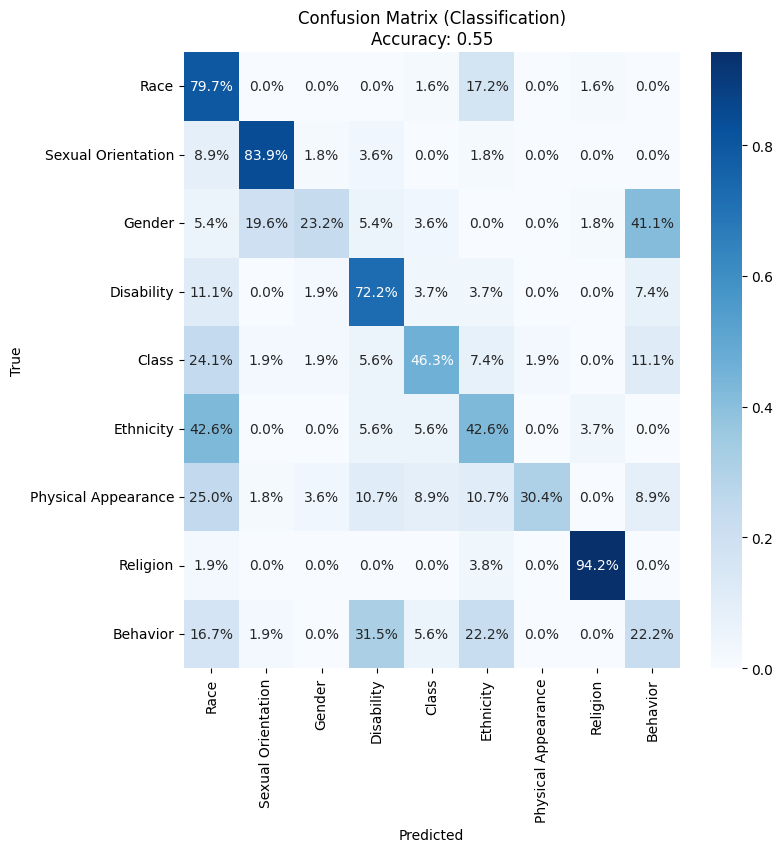

In [46]:
from torch.utils.data import DataLoader, TensorDataset

# Tokenize and prepare input data for testing set
def tokenize_data(text):
    return tokenizer(
        text,
        max_length=128,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )
# tokenized_test = tokenizer(X_test, return_tensors="pt")
tokenized_test = X_test_hate_speech.apply(tokenize_data)
# print(len(tokenized_test))
# print(tokenized_test)

input_ids_test = torch.cat([tokenized_test[i]['input_ids'] for i in range(len(tokenized_test))], dim=0)
attention_masks_test = torch.cat([tokenized_test[i]['attention_mask'] for i in range(len(tokenized_test))], dim=0)
labels_test = torch.tensor(y_test_hate_speech.values)

# Create DataLoader for testing set
dataset_test = TensorDataset(input_ids_test, attention_masks_test, labels_test)
dataloader_test = DataLoader(dataset_test, batch_size=8, shuffle=False)

# Evaluation loop
classification_model.eval()
all_preds = []

with torch.no_grad():
    for batch in dataloader_test:
        input_ids, attention_masks, labels = [tensor.to(device) for tensor in batch]

        outputs = classification_model(input_ids, attention_mask=attention_masks)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        all_preds.extend(preds)


# Evaluate the model
print("BERTweet:")
print(classification_report(y_test_hate_speech, all_preds, target_names=label_dict.keys()))

# Generate confusion matrix
conf_mat = confusion_matrix(y_test_hate_speech, all_preds, normalize='true')  # Normalize the confusion matrix
accuracy_classification = accuracy_score(y_test_hate_speech, all_preds)

# Display the confusion matrix as a heatmap
plt.figure(figsize=(8, 8))
sns.heatmap(conf_mat, annot=True, cmap='Blues', xticklabels=label_dict.keys(), yticklabels=label_dict.keys(), fmt=".1%")
plt.title(f'Confusion Matrix (Classification)\nAccuracy: {accuracy_classification:.2f}')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()